In [1]:
install.packages('MittagLeffleR')
library(MittagLeffleR)

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)
also installing the dependency ‘stabledist’



In [2]:
x = rml(500, 0.3)
logMomentEstimator(x)

nu     delta      nuLo      nuHi   deltaLo   deltaHi 
0.3087750 0.8858894 0.2853034 0.3322467 0.4407631 1.3310156

In [2]:
dens <- function(alpha) {
    function(x) {
        (sin(pi*alpha) * x^(alpha - 1)) / (pi * (1 + x^(2*alpha) + 2*x^(alpha)*cos(pi*alpha)))
    }
}

In [3]:
computeG <- function(lambda, w, x) {
    n = length(x); k = length(w)
    G = matrix(nrow = n, ncol = k)
    for (i in 1:n) {
        for (j in 1:k) {
            G[i,j] = w[j]*lambda[j]*exp(-x[i]*lambda[j])
        }
        if (sum(G[i,]) > 0) {
            G[i,] = G[i,] / sum(G[i,])
        }
    }
    G
}

In [4]:
hist <- function(data) {
    k = length(data[,1])
    lambda = data[,1]
    w = data[,2]
    knots = rep(0, k+1)
    values = rep(0, k+2)
    for (i in 2:k) {
        knots[i] = (lambda[i-1] + lambda[i]) / 2
    }
    knots[1] = if (2 * lambda[1] - knots[2] > 0) 2 * lambda[1] - knots[2] else 0
    knots[k+1] = 2 * lambda[k] - knots[k]
    for (i in 1:k) {
        values[i+1] = w[i] / (knots[i+1] - knots[i])
    }
    stepfun(knots, values)
}

In [5]:
EM <- function(x) {
    n = length(x)
    k = 50
    lambda = quantile(x,seq(1/(2*k),1-1/(2*k),1/k))
    w = rep(1/k, k)
    G = matrix(0L, nrow = n, ncol = k)
    iterations = 0
    tau = 0.001
    repeat {
        G0 = G
        # computing G
        G = computeG(lambda, w, x)
        # recomputing weights
        w = ifelse(colSums(G) / n - tau > 0, colSums(G) / n - tau, 0)
        w = w / sum(w)
        lambda = colSums(G) / (x %*% G)
        iterations = iterations + 1
        # exit
        if ((max(abs(G0-G)) < 0.001)) {
            break
        }
        if (length(which(w == 0)) > 0) {
            lambda = lambda[-which(w == 0)]
            G = G[,-which(w == 0)]
            w = w[-which(w == 0)]
        }
    }
    print(iterations)
    lambda = t(lambda)
    #hist(cbind(lambda, w)[order(lambda),])
    cbind(lambda, w)[order(lambda),]
}

In [9]:
n = 1000
x = rml(n, 0.9)
est = EM(x)

[1] 779


In [8]:
# estimation of mittag leffler distribution density
est = EM(x)
lambda = est[,1]
w = est[,2]
est_ml_dense <- function(x) {
    sapply(x, function(a) w %*% (lambda * exp(-a*lambda)))
}

In [102]:
EM_fixedlambdas <- function(x) {
    n = length(x)
    k = 10
    lambda = seq(0.1,10,9.9/k)
    w = rep(1/k, k)
    G = matrix(0L, nrow = n, ncol = k)
    iterations = 0
    repeat {
        G0 = G
        # computing G
        G = computeG(lambda, w, x)
        # recomputing weights
        w = colSums(G) / n
        #lambda = colSums(G) / (x %*% G)
        iterations = iterations + 1
        # exit
        if ((max(abs(G0-G)) < 1e-4)) {
            break
        }
    }
    print(iterations)
    #lambda = t(lambda)
    #hist(cbind(lambda, w)[order(lambda),])
    cbind(lambda, w)
}

In [91]:
weights <- function(lambda, alpha) {
    k = length(lambda)
    knots = rep(0, k)
    for (i in 2:k) {
        knots[i] = (lambda[i-1] + lambda[i]) / 2
    }
    knots[1] = if (2 * lambda[1] - knots[2] > 0) 2 * lambda[1] - knots[2] else 0
    w = rep(0, k)
    sum = 0
    for (i in 1:(k-1)) {
        w[i] = integrate(dens(alpha),knots[i],knots[i+1])[[1]]
        sum = sum + w[[i]]
    }
    w[k] = 1 - sum
    w
}

[1] 470


Warning message in cbind(lambda, w):
“number of rows of result is not a multiple of vector length (arg 2)”

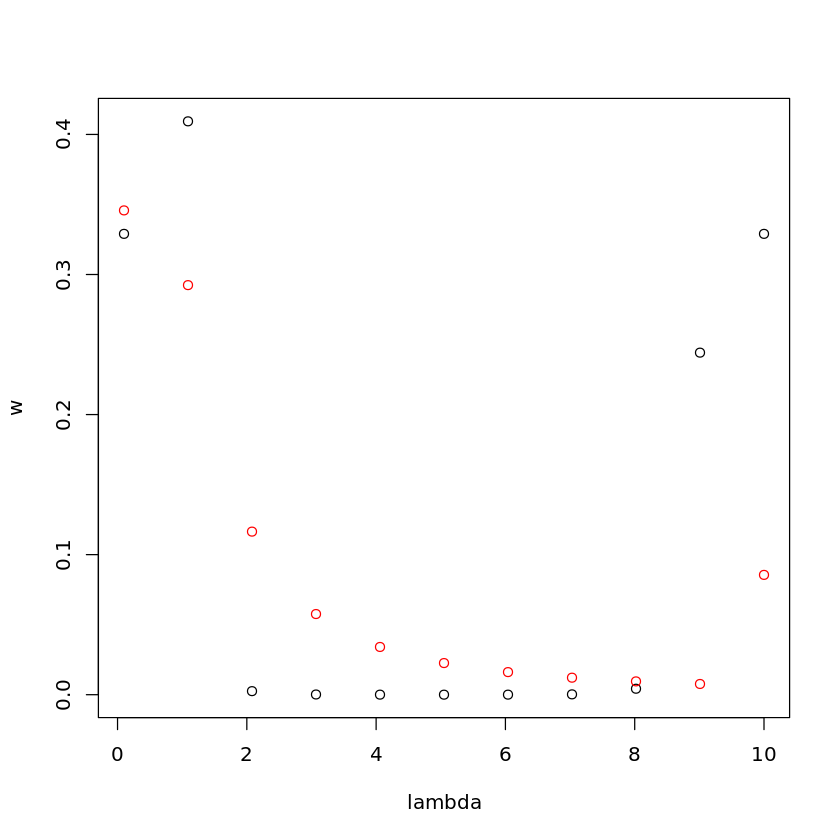

In [106]:
n = 100
x = rml(n, 0.7)
est = EM_fixedlambdas(x)
plot(est)
lambda = est[,1]
w = weights(lambda,0.7)
points(lambda, w, col=2)